<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: Alireza Shafaei
### Student ID: 98101833

# Import necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

# Define the MNIST dataset and data loader

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 146998423.95it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 94859587.96it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 50096641.07it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22679200.91it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Data Visualization

In [ ]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

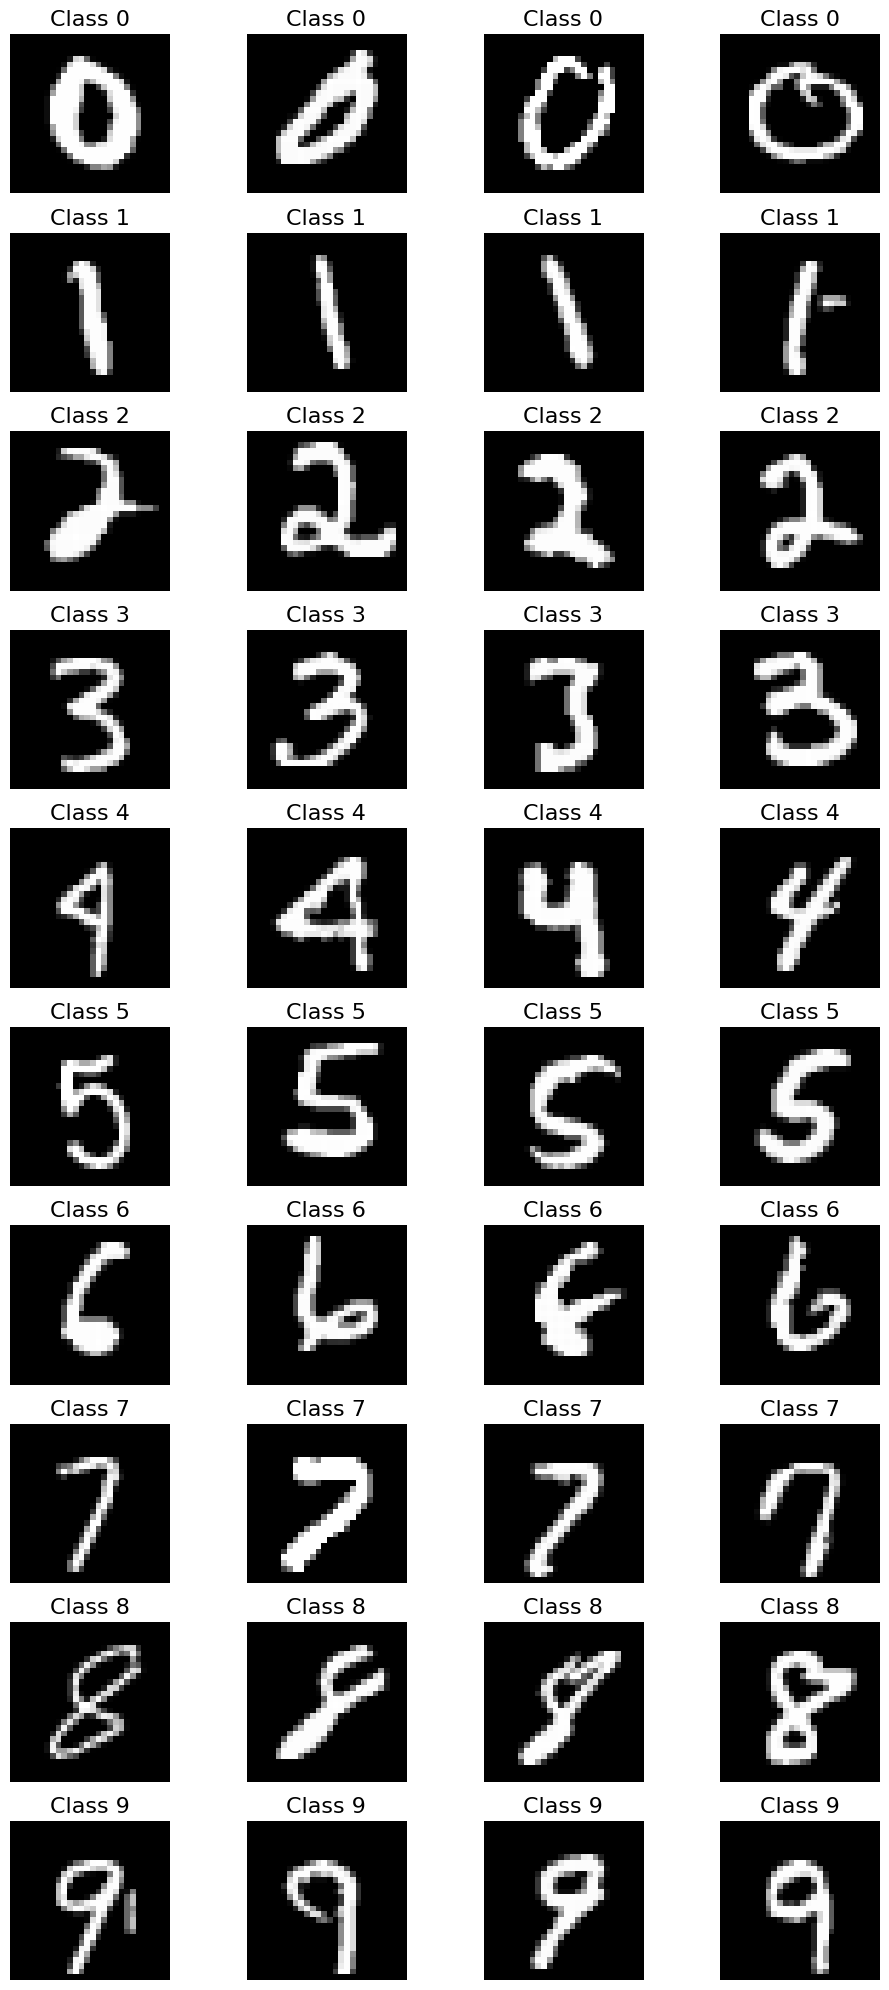

In [ ]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP)

Let's get started!

# 1) VAE --> MLP

In [ ]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder and decoder
        self.encoder = nn.Sequential(
            # TODO: Add layers for the encoder
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)
        )
        self.fc_mu = None
        self.fc_logvar = None
        self.decoder = nn.Sequential(
            # TODO: Add layers for the decoder
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        pass

    def forward(self, x):
        # TODO: Implement the forward pass
        x = x.view(-1, 28 * 28)
        #print(x.shape)
        x_encoded = self.encoder(x)
        #print(x_encoded.shape)
        mu, logvar = torch.chunk(x_encoded, 2, dim=1)

        z = self.reparameterize(mu, logvar)

        x_decoded = self.decoder(z)

        return x_decoded, mu, logvar
        pass

In [ ]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):
    # TODO: Implement the reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data.view(-1, 784), reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # TODO: Return the total loss as the sum of reconstruction and KL divergence losses
    total_loss = reconstruction_loss + kl_divergence
    return total_loss

In [ ]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # TODO: Forward process
            recon, mu, logvar = model(data)

            # TODO: Flatten the data and recon tensors
            data = data.view(-1, 784)
            recon = recon.view(-1, 784)

            # TODO: Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)

            # TODO: Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()  # TODO: Save the model

    # TODO: Save the best model to a file
    torch.save(best_model, 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")



##################################################
VAE-MLP Epoch [1/30], Loss: 178.06610399576823
Sample Images:


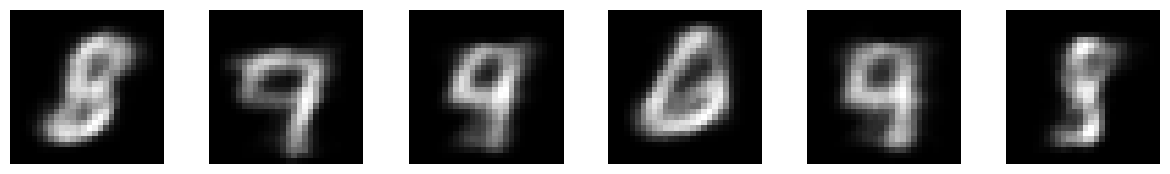


##################################################
VAE-MLP Epoch [2/30], Loss: 158.1205596842448
Sample Images:


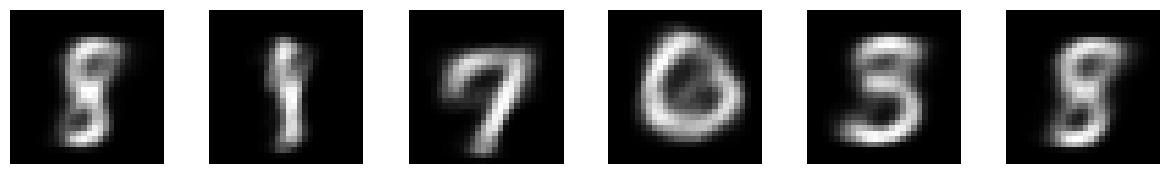


##################################################
VAE-MLP Epoch [3/30], Loss: 152.5727652750651
Sample Images:


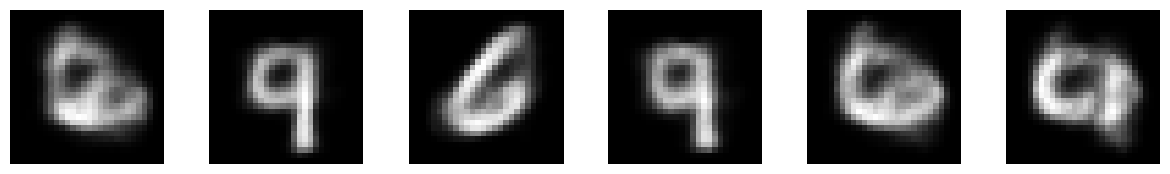


##################################################
VAE-MLP Epoch [4/30], Loss: 149.40645109049478
Sample Images:


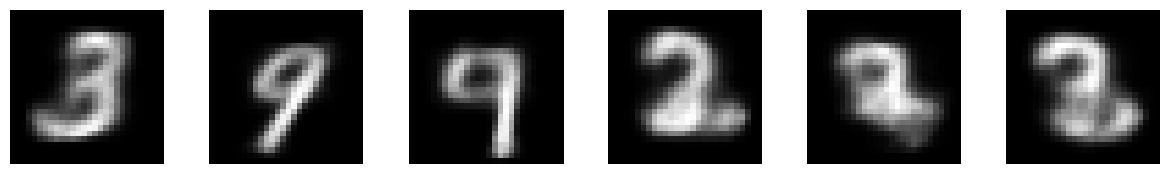


##################################################
VAE-MLP Epoch [5/30], Loss: 147.2619496419271
Sample Images:


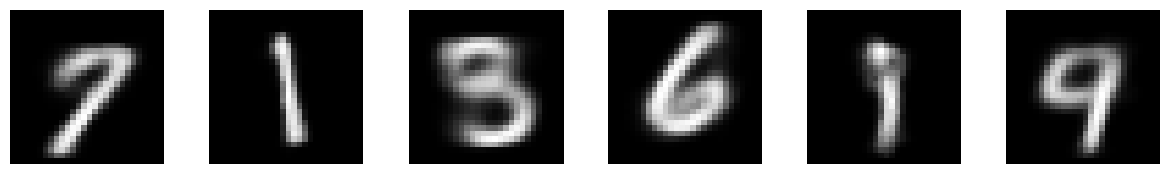


##################################################
VAE-MLP Epoch [6/30], Loss: 145.94380583496093
Sample Images:


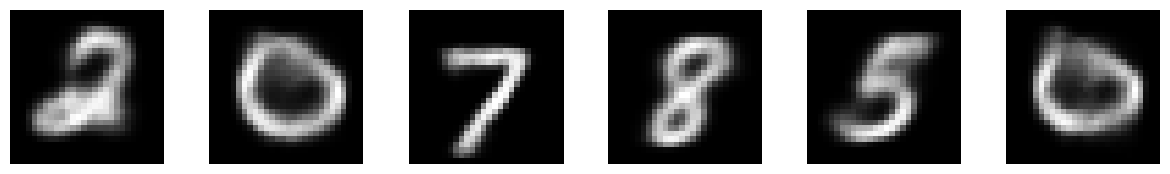


##################################################
VAE-MLP Epoch [7/30], Loss: 144.93637751464843
Sample Images:


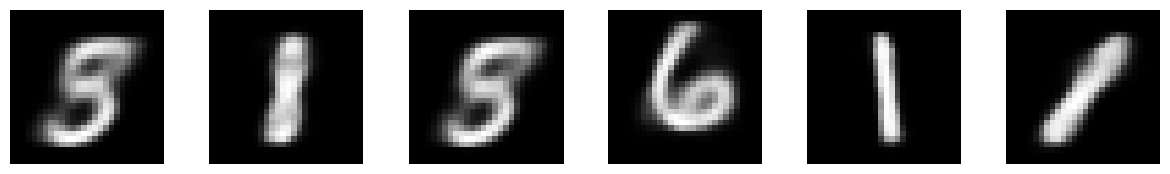


##################################################
VAE-MLP Epoch [8/30], Loss: 144.07451655273437
Sample Images:


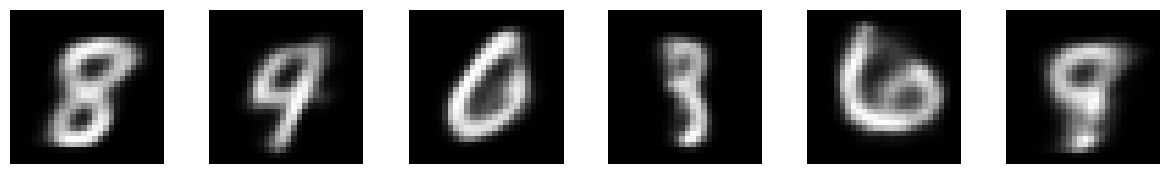


##################################################
VAE-MLP Epoch [9/30], Loss: 143.48167552897135
Sample Images:


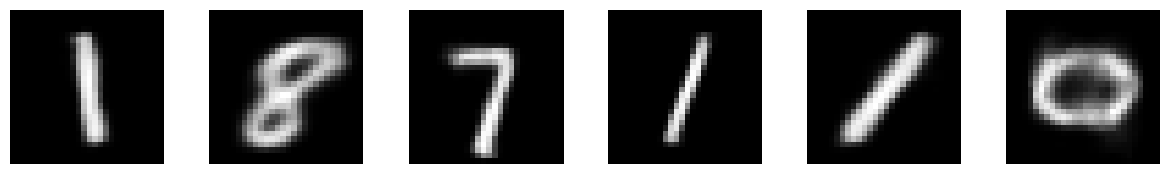


##################################################
VAE-MLP Epoch [10/30], Loss: 142.72088912760415
Sample Images:


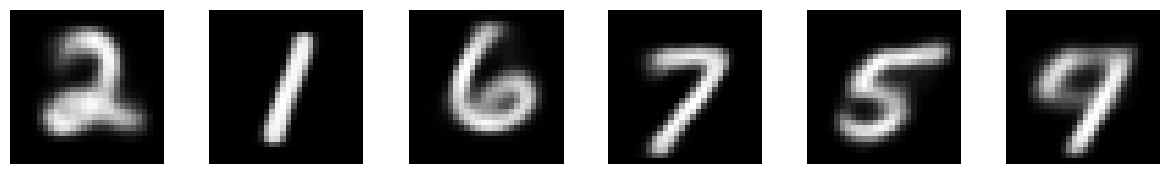


##################################################
VAE-MLP Epoch [11/30], Loss: 142.43929494628907
Sample Images:


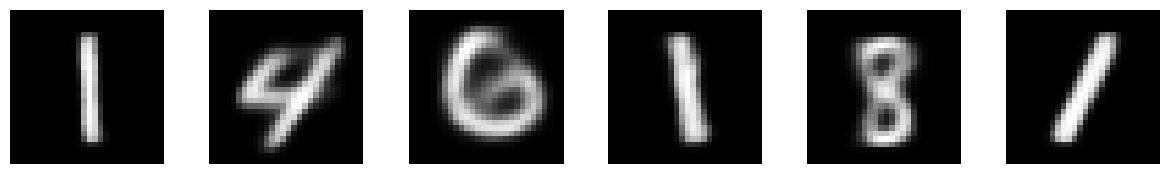


##################################################
VAE-MLP Epoch [12/30], Loss: 142.15299161783855
Sample Images:


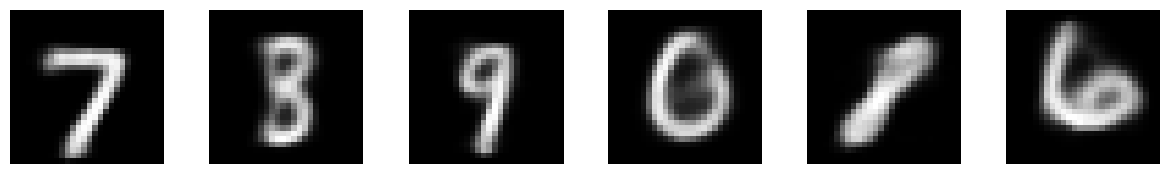


##################################################
VAE-MLP Epoch [13/30], Loss: 141.60981655273437
Sample Images:


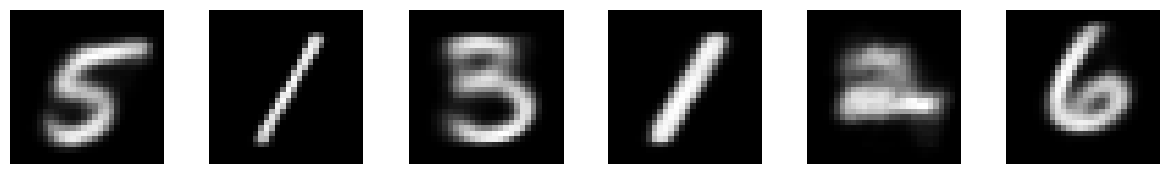


##################################################
VAE-MLP Epoch [14/30], Loss: 140.98142827148436
Sample Images:


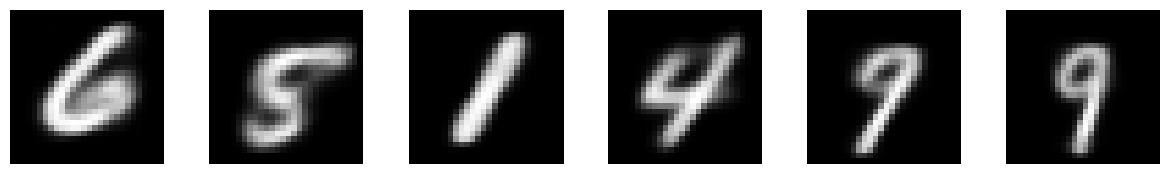


##################################################
VAE-MLP Epoch [15/30], Loss: 140.86215100911457
Sample Images:


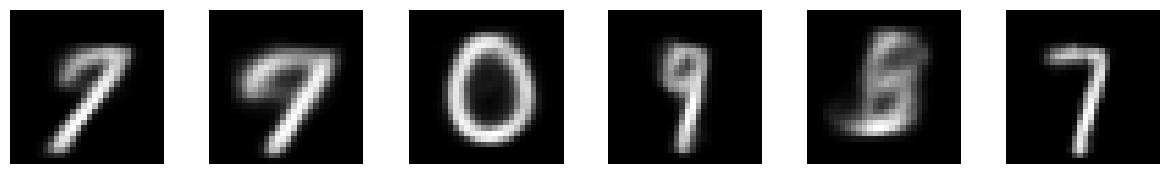


##################################################
VAE-MLP Epoch [16/30], Loss: 140.6491662190755
Sample Images:


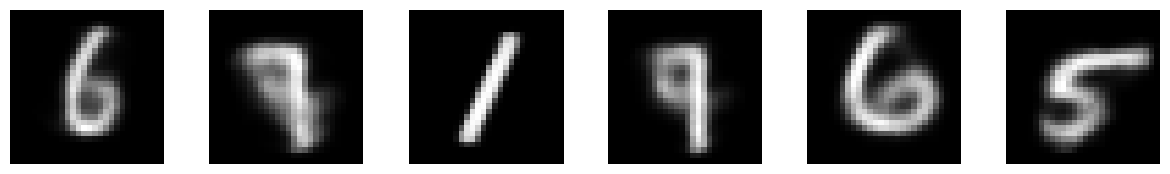


##################################################
VAE-MLP Epoch [17/30], Loss: 140.44222298990886
Sample Images:


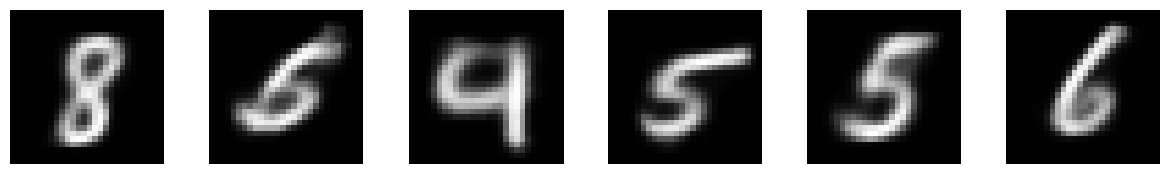


##################################################
VAE-MLP Epoch [18/30], Loss: 140.3227222330729
Sample Images:


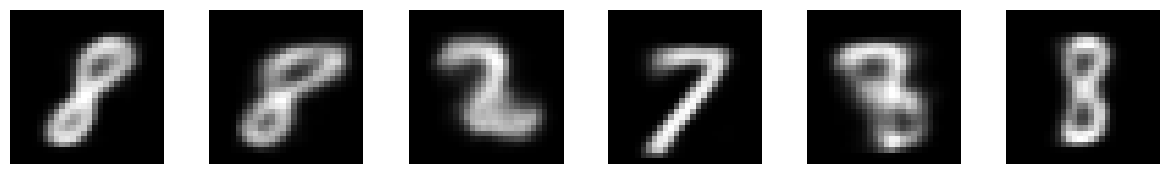


##################################################
VAE-MLP Epoch [19/30], Loss: 139.81645174153647
Sample Images:


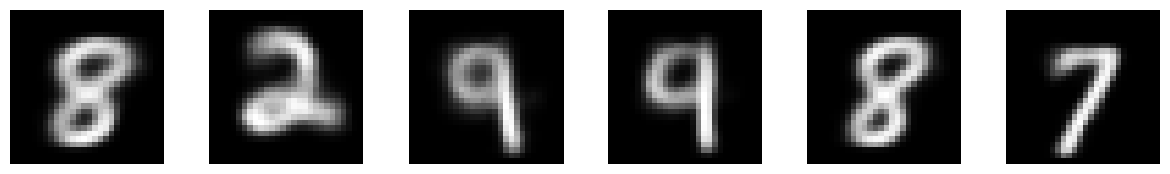


##################################################
VAE-MLP Epoch [20/30], Loss: 139.89144801432292
Sample Images:


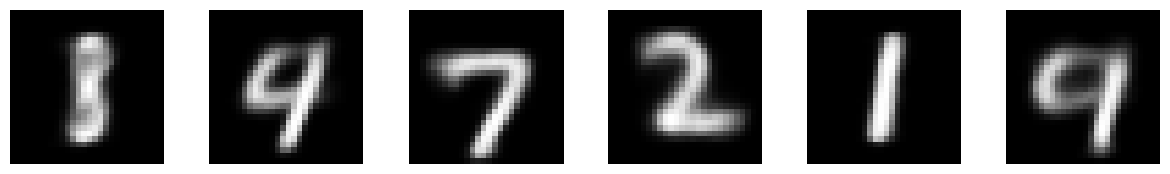


##################################################
VAE-MLP Epoch [21/30], Loss: 139.67351431477866
Sample Images:


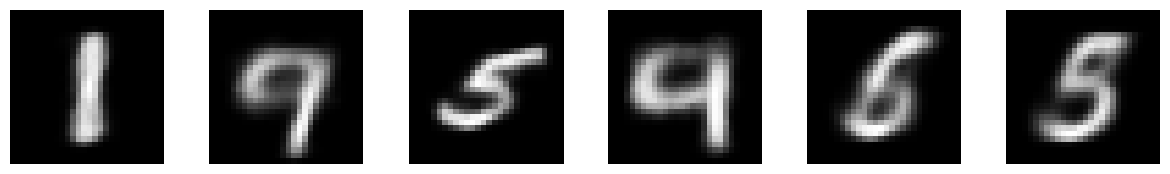


##################################################
VAE-MLP Epoch [22/30], Loss: 139.39379831542968
Sample Images:


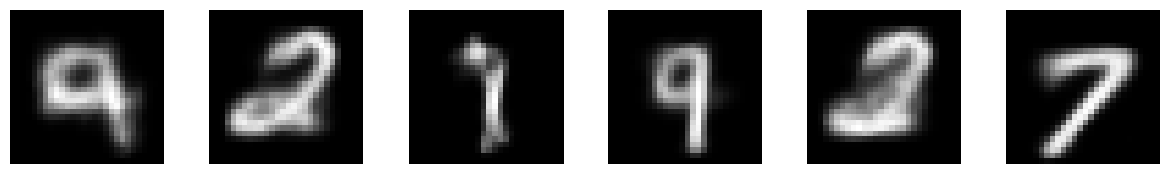


##################################################
VAE-MLP Epoch [23/30], Loss: 139.05702005208335
Sample Images:


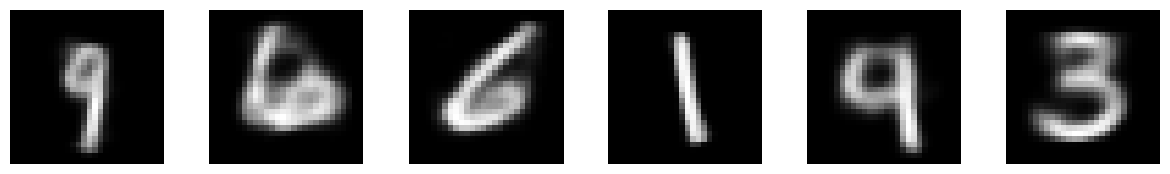


##################################################
VAE-MLP Epoch [24/30], Loss: 138.99448330891926
Sample Images:


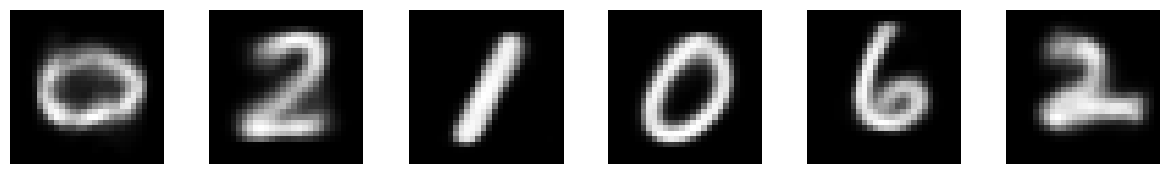


##################################################
VAE-MLP Epoch [25/30], Loss: 138.83419478352866
Sample Images:


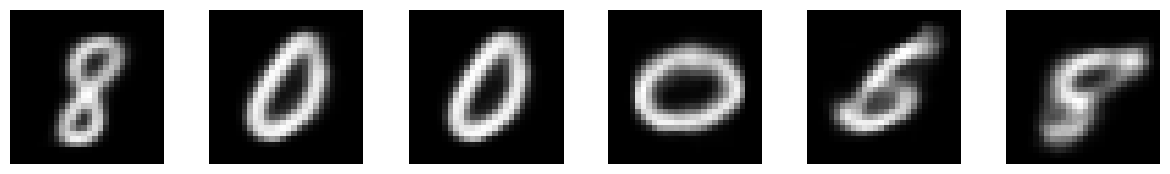


##################################################
VAE-MLP Epoch [26/30], Loss: 138.90820354817708
Sample Images:


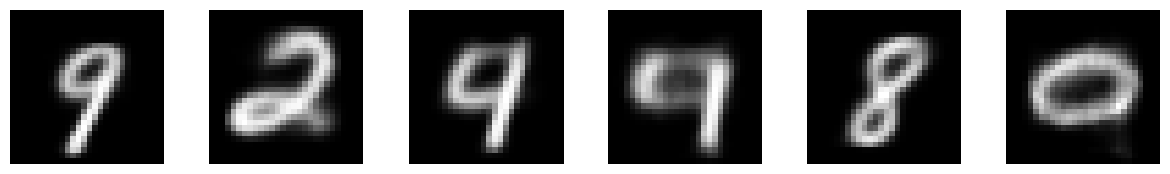


##################################################
VAE-MLP Epoch [27/30], Loss: 138.6740701985677
Sample Images:


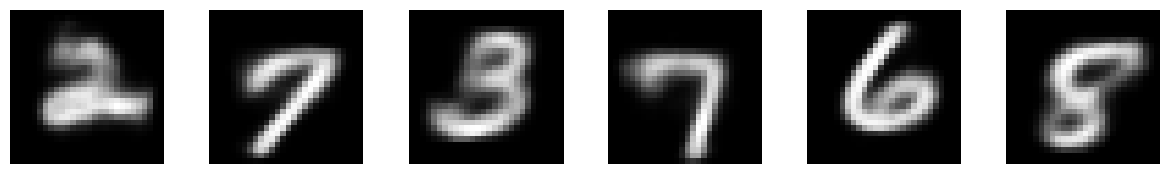


##################################################
VAE-MLP Epoch [28/30], Loss: 138.70884377441405
Sample Images:


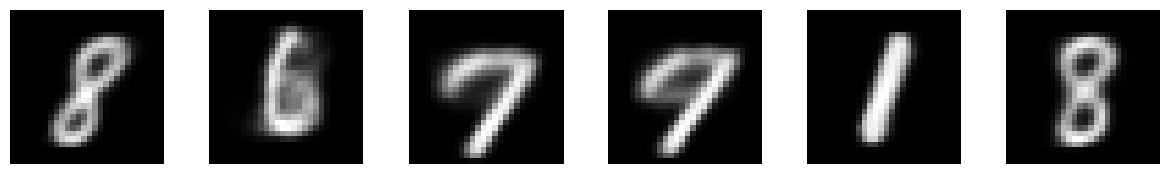


##################################################
VAE-MLP Epoch [29/30], Loss: 138.6368063313802
Sample Images:


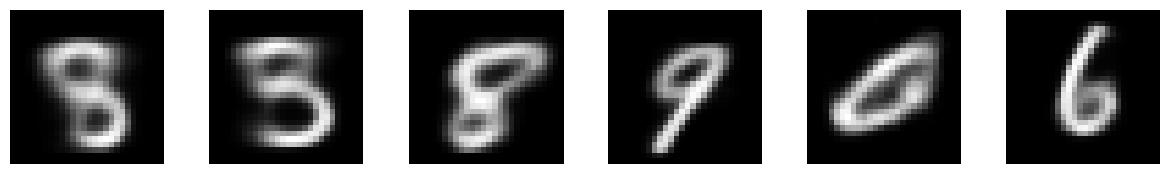


##################################################
VAE-MLP Epoch [30/30], Loss: 138.36552548014322
Sample Images:


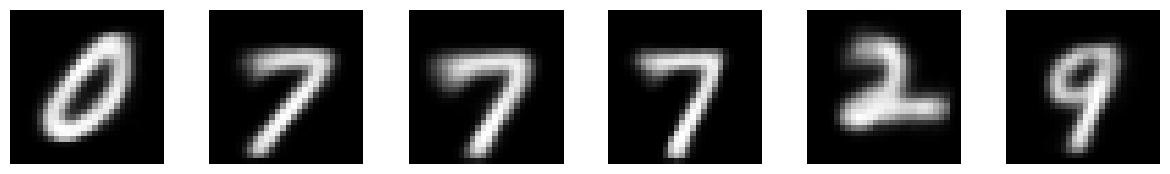

Best model saved as 'best_vae_mlp_model.pth'


In [ ]:
# Train VAE-MLP
input_dim = 784
hidden_dim = 256
latent_dim = 2

vae_mlp = VAE_MLP(input_dim, hidden_dim, latent_dim)
train_vae_mlp(vae_mlp, train_loader, num_epochs=30)

# 2) CVAE --> MLP

In [ ]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder
        self.encoder = nn.Sequential(
            # TODO: Add layers for the encoder
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2 + num_classes)
        )
        self.fc_mu = None
        self.fc_logvar = None
        self.fc_class = None

        # TODO: Define the architecture of the decoder
        self.decoder = nn.Sequential(
            # TODO: Add layers for the decoder
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        pass

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # TODO: Concatenate x and y before passing them to the encoder
        x = torch.cat((x, y), dim=1)

        # TODO: Implement the forward pass
        hidden = self.encoder(x)
        mu, logvar = torch.chunk(hidden[:, :latent_dim * 2], 2, dim=1)
        z = self.reparameterize(mu, logvar)
        class_logits = hidden[:, latent_dim * 2:]
        z = torch.cat((z, y), dim=1)

        reconstructed = self.decoder(z)

        return reconstructed, mu, logvar, class_logits


In [ ]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # TODO: Flatten the data tensor
    data = data.view(-1, 784)

    # TODO: Implement the reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # TODO: Implement the KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # TODO: Implement the cross-entropy loss for class prediction
    ce_loss = F.cross_entropy(class_logits, labels, reduction='sum')

    # TODO: Return the total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    total_loss = reconstruction_loss + kl_divergence + ce_loss
    return total_loss


In [ ]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            # One-hot encode the labels
            labels_one_hot = F.one_hot(labels, num_classes=10).float()

            # TODO: Forward pass through the model and calculate the loss using cvae_loss
            recon, mu, logvar, class_logits = model(data, labels_one_hot)
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)

            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model =  model.state_dict()

    # TODO: Save the best model to a file
    torch.save(best_model, 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################
CVAE-MLP Epoch [1/30], Loss: 163.41782303873697
Sample Images:


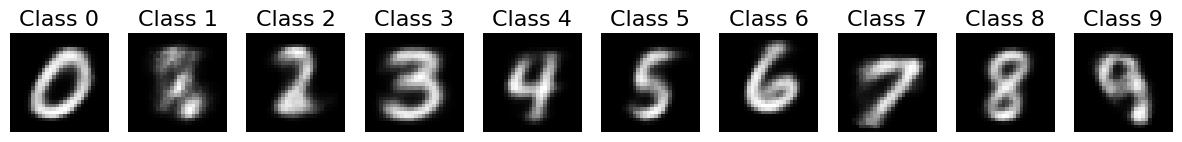


##################################################
CVAE-MLP Epoch [2/30], Loss: 139.20162274576822
Sample Images:


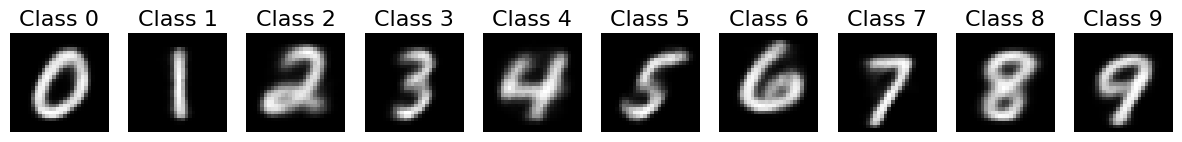


##################################################
CVAE-MLP Epoch [3/30], Loss: 135.53911848958333
Sample Images:


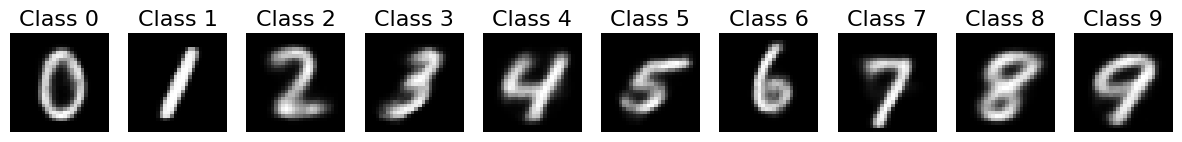


##################################################
CVAE-MLP Epoch [4/30], Loss: 133.72772845865885
Sample Images:


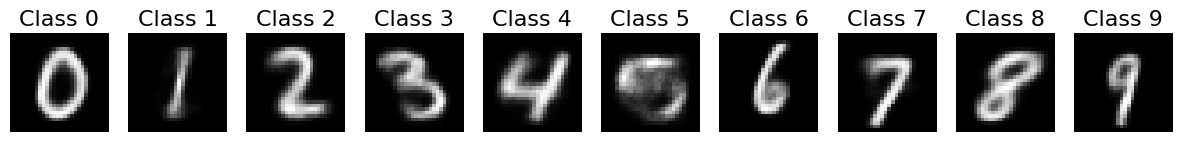


##################################################
CVAE-MLP Epoch [5/30], Loss: 132.5685618652344
Sample Images:


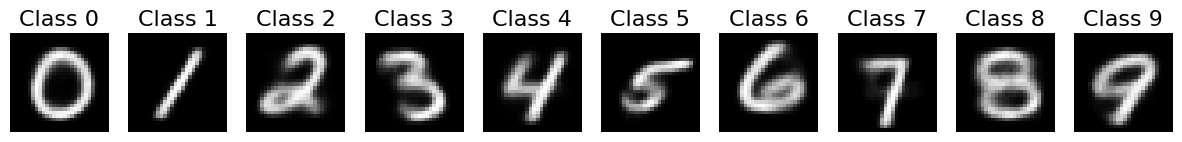


##################################################
CVAE-MLP Epoch [6/30], Loss: 131.84849462076824
Sample Images:


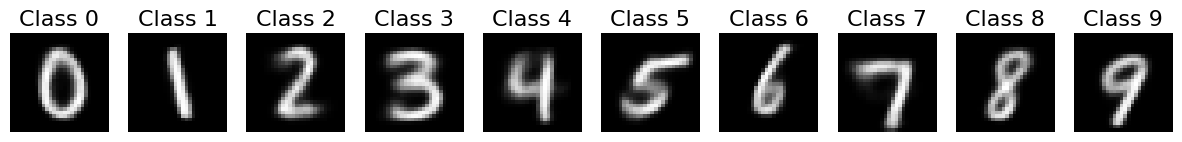


##################################################
CVAE-MLP Epoch [7/30], Loss: 131.27447185872396
Sample Images:


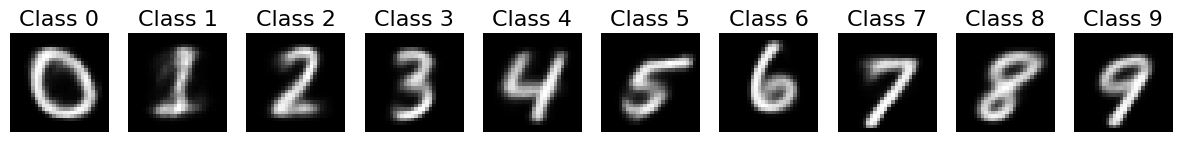


##################################################
CVAE-MLP Epoch [8/30], Loss: 130.7859950480143
Sample Images:


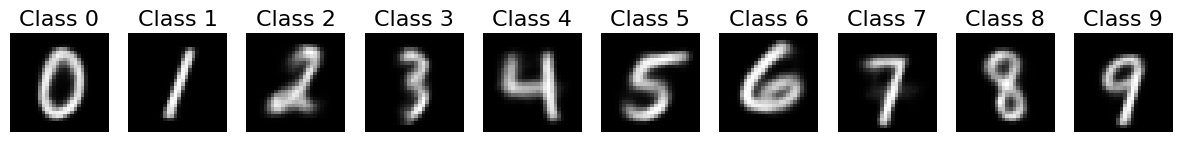


##################################################
CVAE-MLP Epoch [9/30], Loss: 130.3849817545573
Sample Images:


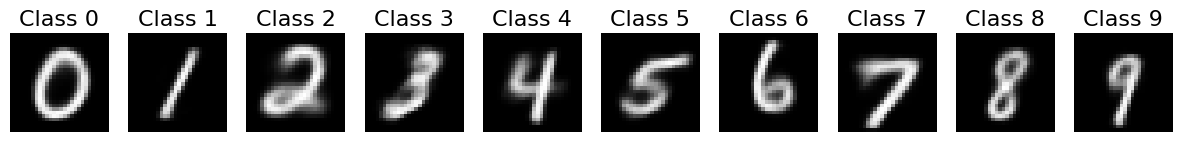


##################################################
CVAE-MLP Epoch [10/30], Loss: 130.03046477864584
Sample Images:


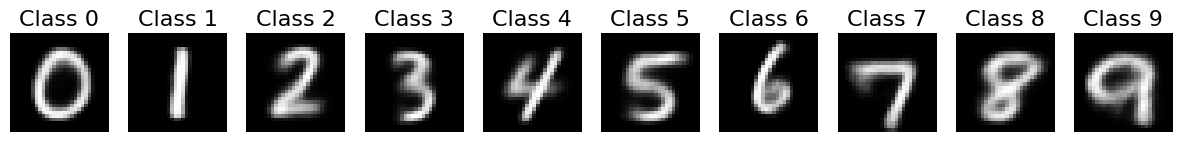


##################################################
CVAE-MLP Epoch [11/30], Loss: 129.72946114095052
Sample Images:


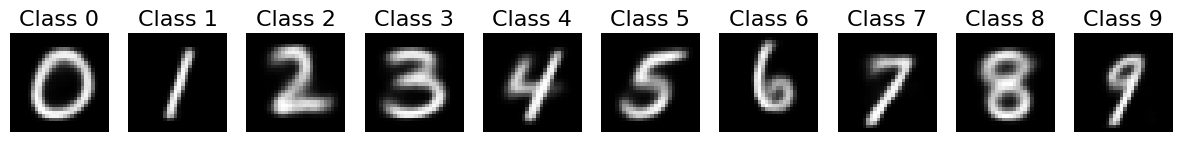


##################################################
CVAE-MLP Epoch [12/30], Loss: 129.46898312988282
Sample Images:


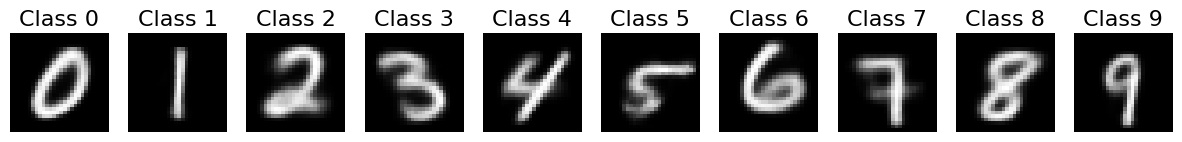


##################################################
CVAE-MLP Epoch [13/30], Loss: 129.17898263346353
Sample Images:


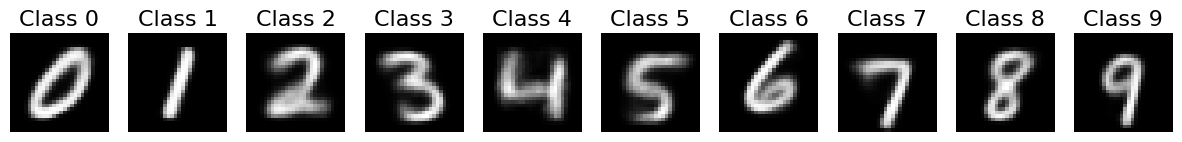


##################################################
CVAE-MLP Epoch [14/30], Loss: 128.95574873453776
Sample Images:


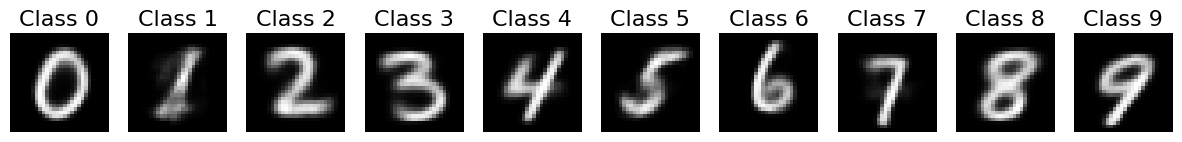


##################################################
CVAE-MLP Epoch [15/30], Loss: 128.71659093017578
Sample Images:


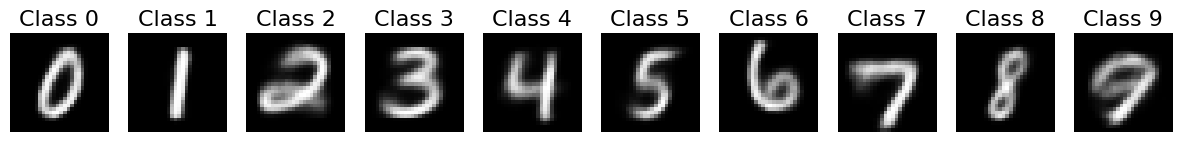


##################################################
CVAE-MLP Epoch [16/30], Loss: 128.50714658203125
Sample Images:


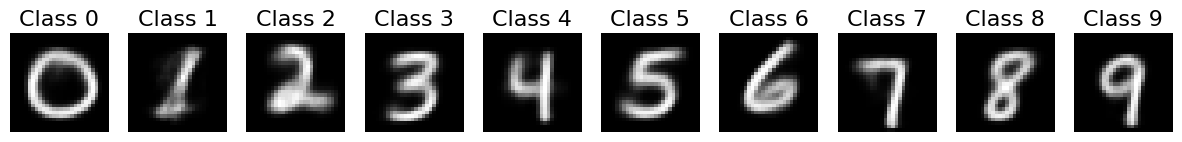


##################################################
CVAE-MLP Epoch [17/30], Loss: 128.27144008789062
Sample Images:


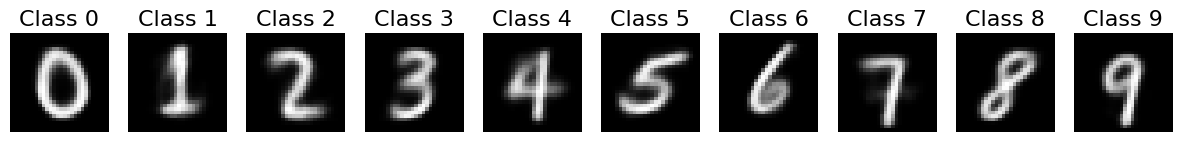


##################################################
CVAE-MLP Epoch [18/30], Loss: 128.1088417154948
Sample Images:


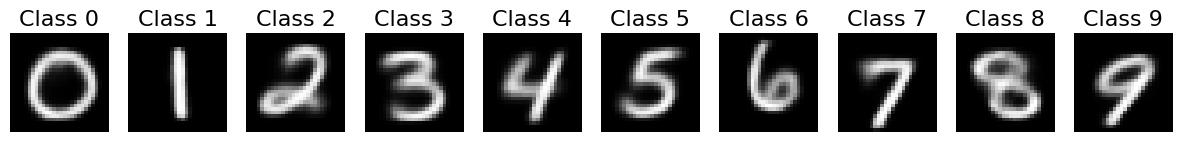


##################################################
CVAE-MLP Epoch [19/30], Loss: 127.8489841023763
Sample Images:


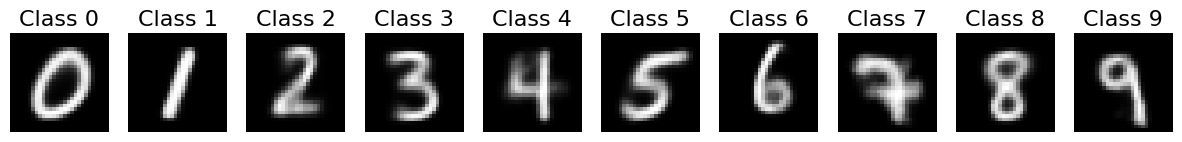


##################################################
CVAE-MLP Epoch [20/30], Loss: 127.69478096923828
Sample Images:


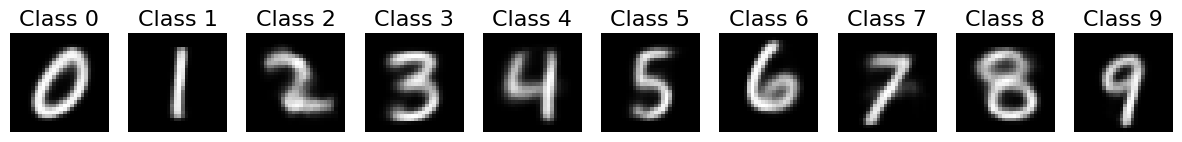


##################################################
CVAE-MLP Epoch [21/30], Loss: 127.54810736490886
Sample Images:


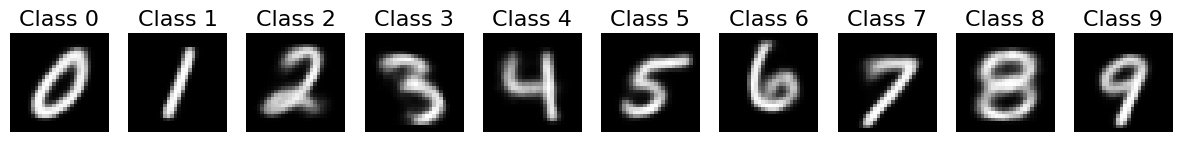


##################################################
CVAE-MLP Epoch [22/30], Loss: 127.36141573079428
Sample Images:


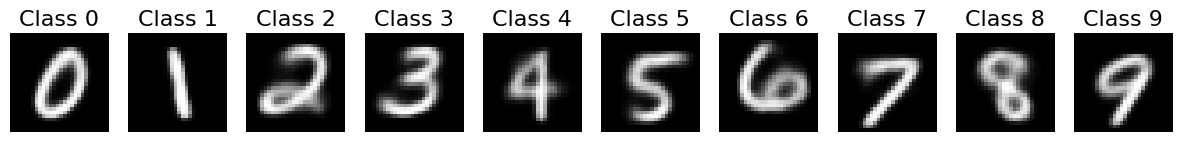


##################################################
CVAE-MLP Epoch [23/30], Loss: 127.29510242513021
Sample Images:


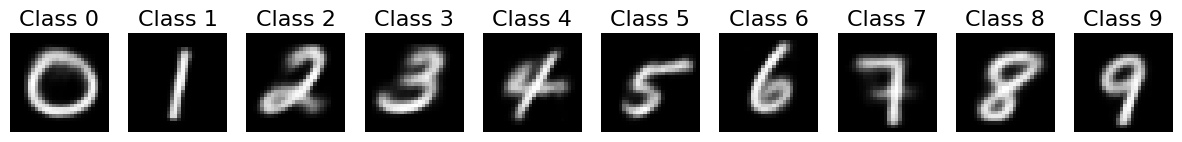


##################################################
CVAE-MLP Epoch [24/30], Loss: 127.0989262125651
Sample Images:


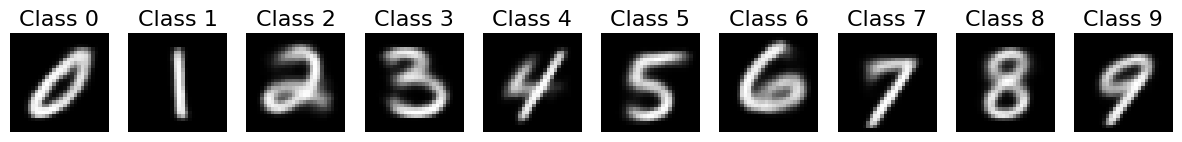


##################################################
CVAE-MLP Epoch [25/30], Loss: 126.92172728678385
Sample Images:


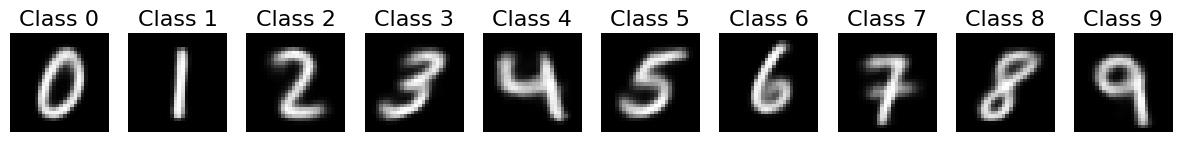


##################################################
CVAE-MLP Epoch [26/30], Loss: 126.78085029296875
Sample Images:


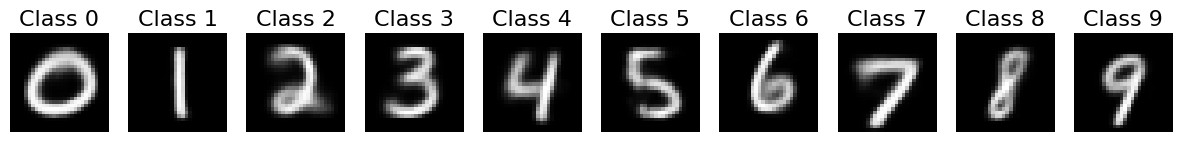


##################################################
CVAE-MLP Epoch [27/30], Loss: 126.67932079671223
Sample Images:


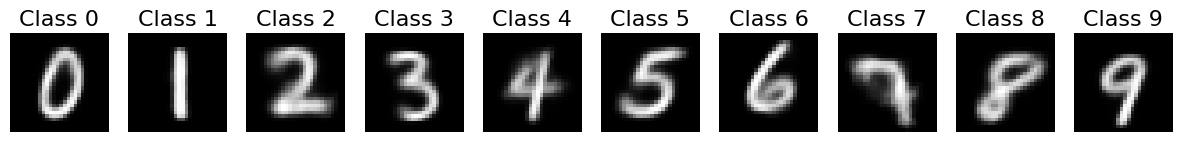


##################################################
CVAE-MLP Epoch [28/30], Loss: 126.55489930826823
Sample Images:


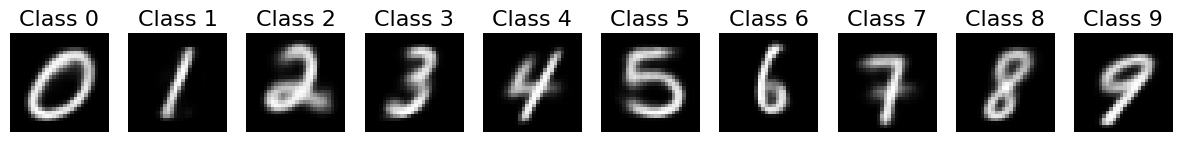


##################################################
CVAE-MLP Epoch [29/30], Loss: 126.42253670247396
Sample Images:


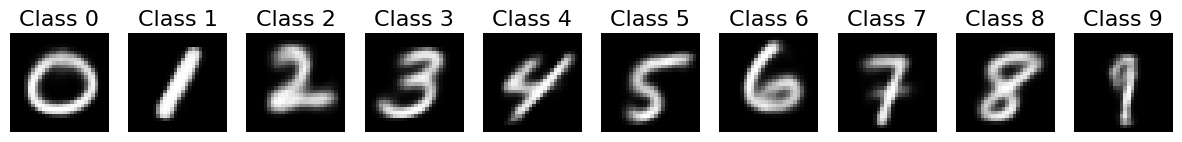


##################################################
CVAE-MLP Epoch [30/30], Loss: 126.42212022298177
Sample Images:


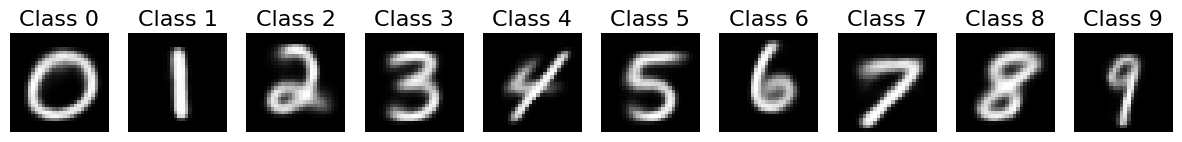

Best model saved as 'best_cvae_mlp_model.pth'


In [ ]:
input_dim = 784
hidden_dim = 256
latent_dim = 2
num_classes = 10

cvae_mlp = CVAE_MLP(input_dim, hidden_dim, latent_dim, num_classes)

train_cvae_mlp(cvae_mlp, train_loader, num_epochs=30)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch

In [ ]:
def visualize_latent_space_vae(model, data_loader):
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for data, label in data_loader:
            _, mu, _ = model(data.view(-1, 784))
            latent_vectors.append(mu)
            labels.append(label)

    latent_vectors = torch.cat(latent_vectors).numpy()
    labels = torch.cat(labels).numpy()

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(latent_vectors)

    plt.figure(figsize=(10, 8))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.title('Latent Space Distribution - VAE (MLP)')
    plt.colorbar()
    plt.show()

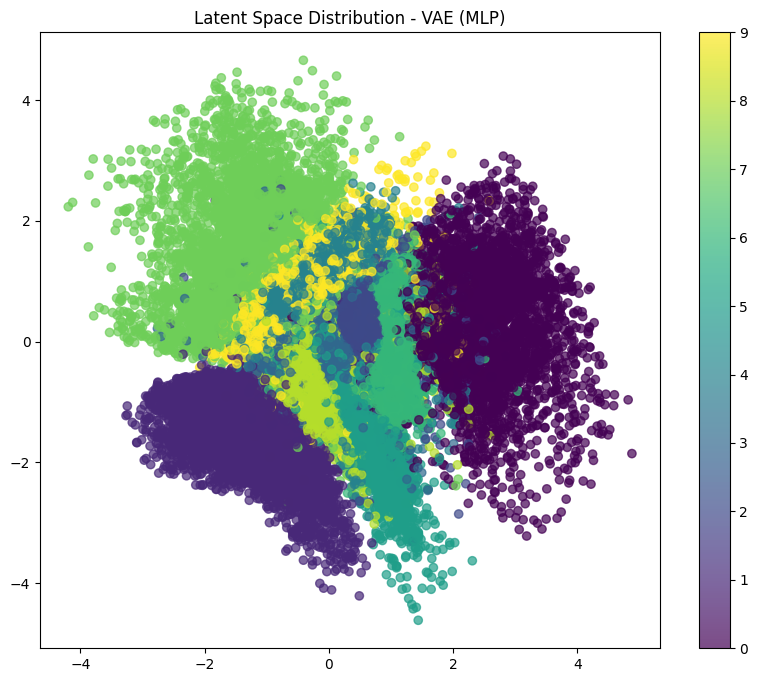

In [ ]:
visualize_latent_space_vae(vae_mlp, train_loader)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch

def visualize_latent_space_cvae(model, data_loader):
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for data, label in data_loader:
            _, mu, _, class_logits = model(data, F.one_hot(label, num_classes=10).float())
            combined_info = torch.cat((mu, class_logits), dim=1)
            latent_vectors.append(combined_info)
            labels.append(label)

    latent_vectors = torch.cat(latent_vectors).numpy()
    labels = torch.cat(labels).numpy()

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(latent_vectors)

    plt.figure(figsize=(10, 8))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.title('Latent Space Distribution - CVAE (MLP) with Class Logits')
    plt.colorbar()
    plt.show()

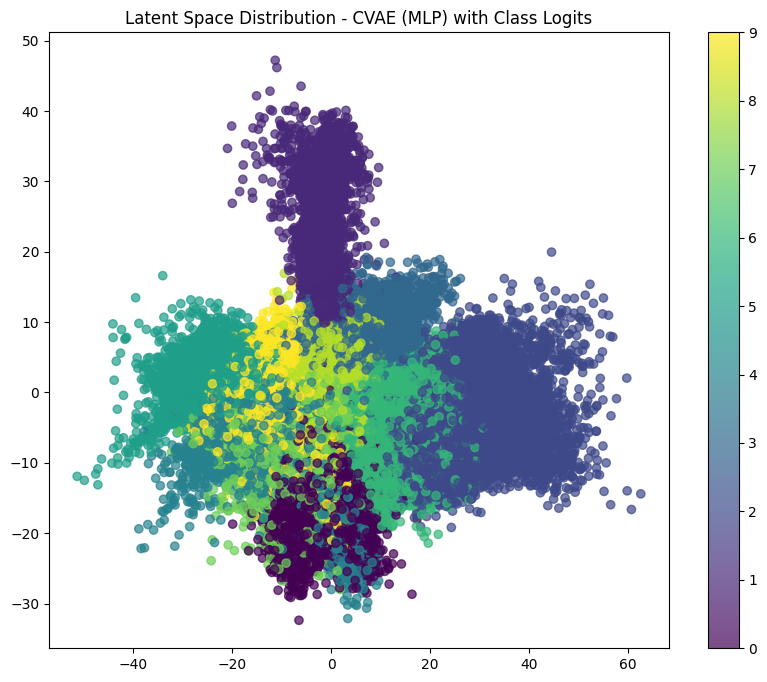

In [ ]:
visualize_latent_space_cvae(cvae_mlp, train_loader)

The Variational Autoencoder (VAE) and Conditional Variational Autoencoder (CVAE) are generative models that extend the capabilities of traditional autoencoders by introducing probabilistic and conditional structures.<br>

Variational Autoencoder (MLP):

Latent Space Distribution: VAEs use a probabilistic approach to model the latent space, assuming a normal distribution. This allows for continuous and smooth transitions in the latent space.<br>
Observations: In the latent space of VAE, similar data points are expected to be close to each other, and the model can generate new samples by sampling from the learned distribution.<br>
Conditional Variational Autoencoder (MLP):

Latent Space Distribution: CVAEs extend VAEs to include conditional information in both the encoding and decoding processes. The latent space is conditioned on input data and a specific class label.<br>
Observations: The latent space of CVAE is structured based on both the data features and the specified class. This allows for more controlled generation of samples by conditioning on specific attributes and provides better separation.<br>
Differences and Conclusions:

Flexibility: CVAE provides a more structured and controlled latent space by incorporating conditional information. This can be beneficial when there is a need to control the generation process based on specific attributes.<br>
Interpretability: CVAE's structured latent space makes it easier to interpret and control the generated samples based on the provided conditions, making it suitable for tasks where interpretability is crucial.<br>
Generative Power: While VAEs have a more flexible latent space, CVAEs can be more powerful in generating samples with desired attributes due to the explicit conditioning on class labels.<br>





